In [24]:
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.metrics import recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import collections as c
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 2000)

In [25]:
# model = pickle.load(open('logistic_regression_completion.p', 'rb')) # load the model

In [26]:
model = LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=50, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.01, verbose=0, warm_start='False')

In [27]:
def scale_subset(df, columns):
    '''
    Use sklearn StandardScalar to scale only numeric columns.

    Parameters:
    ----------
    input {dataframe, list}: dataframe containing mixed feature variable types, list of names of numeric feature columns
    output: {dataframe}: dataframe with numeric features scaled and categorical features unchanged

    '''
    scalar = StandardScaler()
    numeric = df[columns]
    categorical = df.drop(columns, axis = 1)
    scalar.fit(numeric)
    num_scaled = pd.DataFrame(scalar.transform(numeric))
    num_scaled.rename(columns = dict(zip(num_scaled.columns, numeric_cols)), inplace = True)
    return pd.concat([num_scaled, categorical], axis = 1)


In [28]:
X_train = pd.read_csv('../data/processed/first_half/X_train.csv')
y_train = pd.read_csv('../data/processed/first_half/y_train.csv')
# y_train = y_train['module_not_completed']
X_test = pd.read_csv('../data/processed/first_half/X_test.csv')

y_test = pd.read_csv('../data/processed/first_half/y_test.csv')
# y_test = y_test['module_not_completed']

numeric_cols = ['num_of_prev_attempts', 'studied_credits',
'clicks_per_day', 'pct_days_vle_accessed','max_clicks_one_day',
'first_date_vle_accessed', 'avg_score', 'avg_days_sub_early', 'days_early_first_assessment',
'score_first_assessment']

# fill and scale
X_train.fillna(value = 0, inplace = True)
X_train = scale_subset(X_train, numeric_cols)
X_test.fillna(value = 0, inplace = True)
X_test = scale_subset(X_test, numeric_cols)



/Users/jeremymiller/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jeremymiller/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app
/Users/jeremymiller/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jeremymiller/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


In [29]:
# drop features with collinearity (need VIF)
# X_train.drop(withdrawls, inplace=True)
X_train.drop(['days_early_first_assessment', 'pct_days_vle_accessed', 'score_first_assessment'], axis=1, inplace=True)
X_test.drop(['days_early_first_assessment', 'pct_days_vle_accessed', 'score_first_assessment'], axis=1, inplace=True)
# y_train.drop(withdrawls, inplace=True)

In [30]:
y_train = y_train['module_not_completed']
y_test = y_test['module_not_completed']

In [31]:
model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start='False')

In [32]:
predictions = model.predict(X_test)

In [33]:
recall = recall_score(y_test, predictions, average = 'micro')
recall

0.7978802528821123

In [34]:
roc_auc = roc_auc_score(y_test, predictions)
roc_auc

0.7997893212330086

In [36]:
probas = model.predict_proba(X_test)[:, :1]
tprs, fprs, thresh = roc_curve(y_test, probas)

In [37]:
probas

array([[0.72015629],
       [0.38484621],
       [0.96534415],
       ...,
       [0.00450791],
       [0.72043962],
       [0.66442493]])

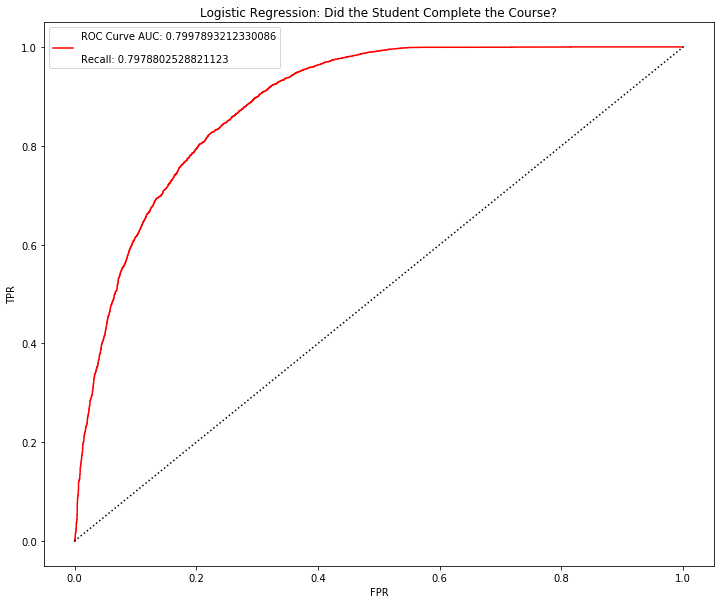

In [38]:
plt.figure(figsize=(12,10))
plt.plot(fprs, tprs, 
    label='ROC Curve AUC: {}\n\nRecall: {}'.format(roc_auc, recall),
    color='red')
plt.plot([0,1],[0,1], 'k:')
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Logistic Regression: Did the Student Complete the Course?")
plt.show()

In [48]:
cross_val_score(model, X_train, y_train, scoring='roc_auc')

/Users/jeremymiller/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.88342042, 0.88585959, 0.87983924])

In [ ]:
# pd.DataFrame(data={'fprs': fprs, 'tprs': tprs, 'Thresholds': thresh})

# Which features are most important?

In [ ]:
sm.stats.outliers_influence.va

In [ ]:
y_test.shape

In [44]:
abs_coef = list(np.abs(model.coef_.ravel()))
features = list(X_test.columns)

In [45]:
coef_dict = c.OrderedDict((zip(abs_coef, features)))

In [46]:
sorted(coef_dict.items(), reverse=True)

[(0.9307190668558917, 'avg_score'),
 (0.7785105898057149, 'code_module_FFF'),
 (0.6821957458855157, 'code_module_CCC'),
 (0.5273641874480828, 'clicks_per_day'),
 (0.5066192581435509, 'code_presentation_2014J'),
 (0.47568860047684536, 'code_module_EEE'),
 (0.4659699266157732, 'code_module_DDD'),
 (0.4482582000390297, 'code_presentation_2013J'),
 (0.4110760031776286, 'imd_band_nan'),
 (0.3359778427765509, 'code_module_GGG'),
 (0.32940058770228026, 'highest_education_No Formal quals'),
 (0.24824310387336915, 'highest_education_Lower Than A Level'),
 (0.2426719569653204, 'imd_band_90-100%'),
 (0.19765076507481852, 'imd_band_60-70%'),
 (0.19136835034362115, 'imd_band_80-90%'),
 (0.1724931850689187, 'imd_band_30-40%'),
 (0.16411830949037362, 'imd_band_70-80%'),
 (0.16307277733839573, 'imd_band_50-60%'),
 (0.15984857640628486, 'code_presentation_2014B'),
 (0.13791217715420956, 'region_Wales'),
 (0.13495046097349322, 'age_band_55<='),
 (0.1302760469025025, 'region_Scotland'),
 (0.1278852943718

In [39]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.76      0.83      0.79      5062
        True       0.84      0.77      0.80      5694

   micro avg       0.80      0.80      0.80     10756
   macro avg       0.80      0.80      0.80     10756
weighted avg       0.80      0.80      0.80     10756



In [49]:
accuracy_score(y_test, predictions)

0.7978802528821123

In [15]:
print(confusion_matrix(y_test, predictions))

[[2350  236  672   30]
 [ 885  503  996   22]
 [ 251  236 3418  137]
 [   4    7  776  233]]


In [16]:
# pickle.dump(model, open('logistic_regression_completion.p', 'wb')) # pickle the model

Correlated predictor variables

In [40]:
cor = X_train.corr().abs()

In [41]:
s = cor.unstack()

In [42]:
so = s.sort_values(kind="quicksort", ascending=False)

In [43]:
so[::2]

disability_Y                                   disability_Y                                     1.000000
region_Scotland                                region_Scotland                                  1.000000
region_South Region                            region_South Region                              1.000000
region_Wales                                   region_Wales                                     1.000000
region_Yorkshire Region                        region_Yorkshire Region                          1.000000
highest_education_Lower Than A Level           highest_education_Lower Than A Level             1.000000
highest_education_Post Graduate Qualification  highest_education_Post Graduate Qualification    1.000000
imd_band_20-30%                                imd_band_20-30%                                  1.000000
imd_band_40-50%                                imd_band_40-50%                                  1.000000
imd_band_60-70%                                imd_band